# Replication of Quant GANs Paper 
# (https://arxiv.org/pdf/1907.06673.pdf)
# Using PyTorch

# Submission by TEE Yu Shiang


## 1. Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For export of notebook to HTML

# %%shell
# jupyter nbconvert --to html "/content/drive/MyDrive/QuantGAN/submission/quantgan_torch.ipynb"

In [3]:
%%capture

!pip install yfinance

# https://www.learnpythonwithrune.org/fix-get_data_yahoo-from-pandas-datareader/
!pip install --upgrade pandas-datareader

In [4]:
# https://pypi.org/project/yfinance/?msclkid=d46ae456c76b11ecb6cc4feb96d79192

import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()


import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from time import sleep

from typing import Text, List, Union
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import stats
from scipy import optimize
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
import os
import sys

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

# 2. Utility Code

In [5]:
# Reference: https://github.com/ICascha/QuantGANs-replication/blob/main/backend/gaussianize.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Transform data so that it is approximately normally distributed

This code written by Greg Ver Steeg, 2015.
"""
np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x

class Gaussianize(sklearn.base.TransformerMixin):

    def __init__(self, strategy: Text = 'lambert', 
                 tol: float = 1e-5, 
                 max_iter: int = 100, 
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose
        
    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)
        
        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    # def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
    #     """Show qq plots compared to normal before and after the transform."""
    #     x = _update_x(x)
    #     y = self.transform(x)
    #     n_dim = y.shape[1]
    #     for i in range(n_dim):
    #         stats.probplot(x[:, i], dist="norm", plot=plt)
    #         plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
    #         plt.clf()
    #         stats.probplot(y[:, i], dist="norm", plot=plt)
    #         plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
    #         plt.clf()

def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))

def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1

def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)

def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0


In [6]:
# Reference: https://github.com/ICascha/QuantGANs-replication/blob/main/backend/preprocessing.py

def rolling_window(x, k, sparse=True):

    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]
            
    if not sparse:
        return out

    return out[:, :-(k-1)]


In [7]:
# Reference: https://github.com/ICascha/QuantGANs-replication/blob/main/backend/metrics.py

def acf(x, k, le=False):

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):
    
    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))
    
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))


In [8]:
# Reference: https://github.com/ICascha/QuantGANs-replication/blob/main/backend/clustering.py

def clustering(real_returns, synth_returns, window_length, n_clusters, random_state=0):

    real_samples = rolling_window(real_returns, window_length).T.reshape((-1, window_length))
    # We cluster based on synth samples, so we skip ahead twice the window length
    # to avoid interdependencies of windows
    synth_samples = rolling_window(synth_returns, window_length)[:, ::window_length*2].T.reshape((-1, window_length))
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(synth_samples)

    real_bins = kmeans.predict(real_samples)
    synth_bins = kmeans.predict(synth_samples)

    real_freq = np.bincount(real_bins)
    synth_freq = np.bincount(synth_bins)

    total_freq = np.stack([real_freq, synth_freq])
    total_freq = total_freq / total_freq.sum(axis=1, keepdims=True)

    return real_samples, synth_samples, real_bins, synth_bins, total_freq.T, kmeans

def plot_clustering(synth_samples, synth_bins, alpha, bins, figsize):

    fig, axs = plt.subplots(figsize=figsize, nrows=3, ncols=3, sharex=True, sharey=True)

    i = 0
    j = 0
    for bin in bins:
        axs[i, j].plot(np.moveaxis(synth_samples[synth_bins == bin], 0, -1), color='orange', alpha=alpha)
        axs[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
        axs[i, j].grid(axis='y', which='major')

        j += 1
        j = j % 3
        if j == 0:
            i += 1

    plt.setp(axs[-1, :], xlabel='time (days)')
    plt.setp(axs[:, 0], ylabel='log return')

    return fig, axs

In [9]:
# Reference: https://github.com/locuslab/TCN/blob/master/TCN/tcn.py

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):

    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.relu(out + res)


## 3. Load Data (Amend Stock Symbol, Start Date, End Date here)

In [10]:
# Amend Stock Symbol, Start and End Dates
df = pdr.get_data_yahoo("^GSPC", start="2009-5-1", end="2018-12-31")['Adj Close']


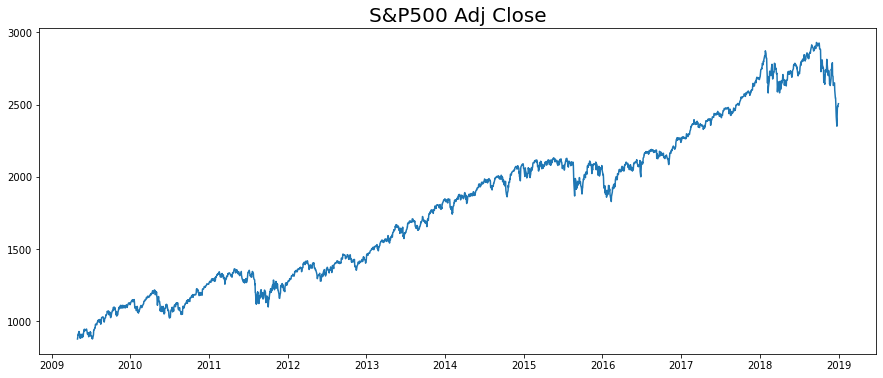

In [11]:
fig = plt.figure(figsize=(15,6))
plt.title(f'S&P500 Adj Close', fontsize=20)
plt.plot(df)
plt.show()


In [12]:
class QGLoader(Dataset):
    
    def __init__(self, data, length):
        self.data = data
        self.length = length
    
    def __getitem__(self, i):
        return torch.tensor(self.data[i : i + self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
SS1, SS2, gaussianize = StandardScaler(), StandardScaler(), Gaussianize()
log_returns_preproc = SS1.fit_transform(gaussianize.fit_transform(SS2.fit_transform(log_returns)))

## 4. Define and Train Model

In [13]:
# Define Generator and Degenerator classes
# According to Table 3 TCN architecture of the reported models (under B Architecture), p.30 of paper.

class Generator(nn.Module):
 
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=1, padding=1), 
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=2, padding=2),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=4, padding=4),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=8, padding=8),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=16, padding=16),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=32, padding=32)                                 
                                 ])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skips = []
        for f in self.tcn:
            skip, x = f(x)
            skips.append(skip)
        x = self.last(x + sum(skips))
        return x


class Discriminator(nn.Module):

    def __init__(self, rfs, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=1, padding=1), 
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=2, padding=2),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=4, padding=4),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=8, padding=8),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=16, padding=16),
                                  TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=32, padding=32)                        
                                ])
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(1, rfs), nn.Sigmoid())

    def forward(self, x):
        skips = []
        for f in self.tcn:
            skip, x = f(x)
            skips.append(skip)
        x = self.last(x + sum(skips))
        return self.to_prob(x).squeeze()

In [14]:
# Train Model

device = torch.device("cuda:0") 
num_epochs = 500
batch_size = 80
nz = 3
rfs = 127
clip= 0.01
lr = 0.001

G = Generator().to(device)
D = Discriminator(rfs).to(device)
opt_D = optim.RMSprop(D.parameters(), lr=lr)
opt_G = optim.RMSprop(G.parameters(), lr=lr)

dataloader = torch.utils.data.DataLoader(QGLoader(log_returns_preproc, 1), batch_size=batch_size)
t = tqdm(range(num_epochs))
for epoch in t:
  for i, data in enumerate(dataloader, 0):
    D.zero_grad()
    real = data.to(device)
    noise = torch.randn(real.size(0), nz, real.size(1), device=device)
    generated = G(noise).detach()
    d_generated = D(generated)
    d_real = D(real)
    loss_D = torch.mean(D(generated)) 
    loss_D += -torch.mean(D(real)) 

    loss_D.backward()
    opt_D.step()
    for p in D.parameters():
      p.data.clamp_(-clip, clip)
    if i % 5 == 0:
      G.zero_grad()
      loss_G = -torch.mean(D(G(noise)))
      loss_G.backward()
      opt_G.step()            
      t.set_description('loss_D: %.12f loss_G: %.12f' % (loss_D.item(), loss_G.item()))
    if epoch == num_epochs - 1:
      torch.save(G, f'./G_epoch_{epoch}.pth')


loss_D: 0.000000000000 loss_G: -0.500138640404: 100%|██████████| 500/500 [08:48<00:00,  1.06s/it]


## 5. Model Eval and Visualizations

In [15]:
G = torch.load(f'./G_epoch_{num_epochs-1}.pth')
G.eval()
noise = torch.randn(80,3,127).to(device)
y = G(noise).cpu().detach().squeeze();
y = SS1.inverse_transform((y - y.mean(axis=0))/y.std(axis=0))
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = SS2.inverse_transform(y)


In [16]:
# Visualize Generated Log Paths
# Corresponds to Figures A.1 and A.2 (under A Numerical Results, A.1 Pure TCN ), p.24 of paper.

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
num_gen_path = [5, 50]

for i in range(len(num_gen_path)):
  ax[i].plot(np.cumsum(y[0:num_gen_path[i]], axis=1).T)
  ax[i].set_title(str(num_gen_path[i]) + ' Generated Log Paths')
  ax[i].set_xlabel('T (Number of Days')
  ax[i].set_ylabel('Log Path')

In [17]:
# Plot comparison of generated and historical densities of the S&P 500
# Corresponds to Figure A.3 (under A Numerical Results, A.1 Pure TCN ), p.25 of paper.

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
n_bins = 50
windows = [1, 7, 30, 100]
label = ["Daily", "Weekly", "Monthly", "100-day"]

for i in range(len(windows)):
    real = rolling_window(log_returns, windows[i], sparse = not(windows[i] == 1)).sum(axis=0).ravel()
    generated = rolling_window(y.T, windows[i], sparse = not(windows[i] == 1)).sum(axis=0).ravel()
    axs[i].hist(np.array([real, generated], dtype='object'), bins=n_bins, density=True)    
    axs[i].set_title('{}'.format(label[i]), size=16)
    axs[i].yaxis.grid(True)
    axs[i].set_xlabel('Log Return')
    axs[i].set_ylabel('Density')
    axs[i].legend(['Historical', 'Generated'])

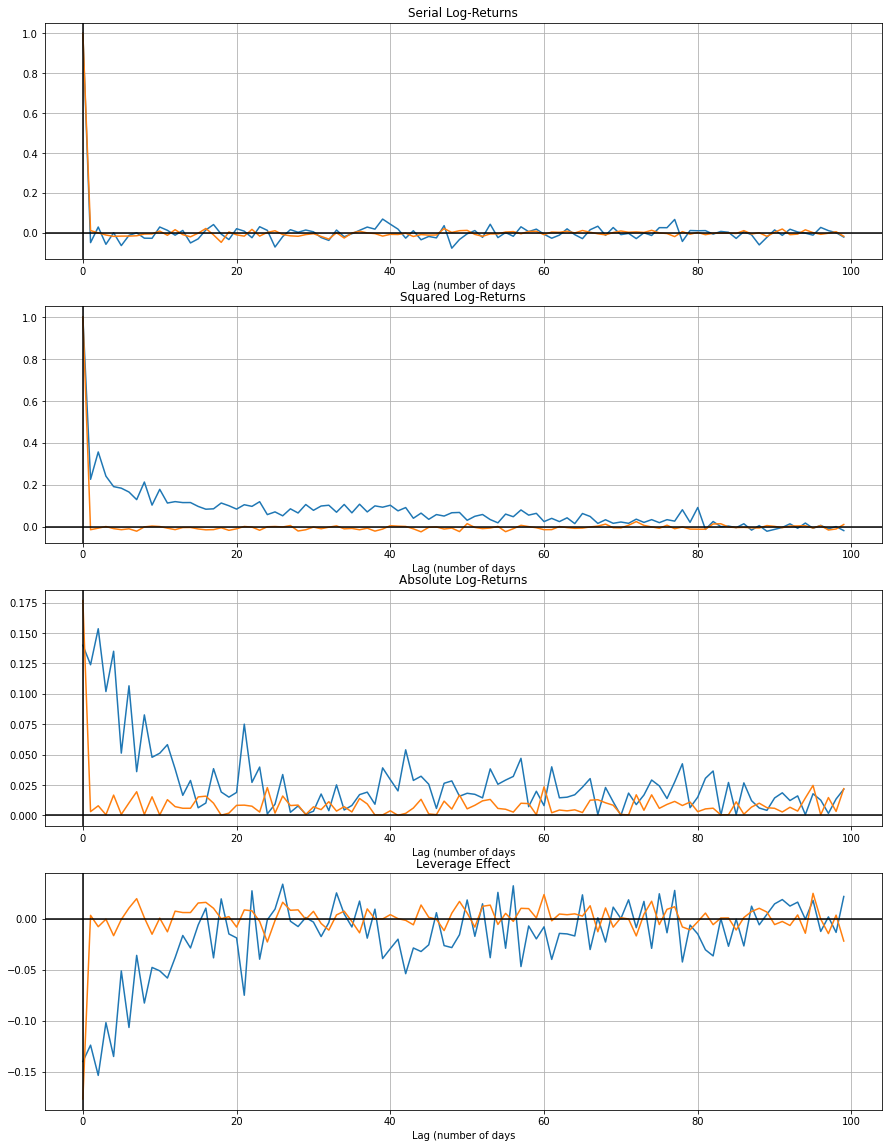

In [18]:
# Plot Mean autocorrelation function of the absolute, squared, and identical log returns and leverage effect 
# Corresponds to Figure A.4 (under A Numerical Results, A.1 Pure TCN ), p.25 of paper.

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))

axs[0].plot(acf(log_returns, 100))
axs[0].plot(acf(y.T, 100).mean(axis=1))
axs[0].set_title('Serial Log-Returns')

axs[1].plot(acf(log_returns**2, 100))
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared Log-Returns')

axs[2].plot(abs(acf(log_returns, 100, le=True)))
axs[2].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[2].set_title('Absolute Log-Returns')

axs[3].plot(acf(log_returns, 100, le=True))
axs[3].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[3].set_title('Leverage Effect')

plt.setp(axs, xlabel='Lag (number of days')

for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')


## APPENDIX: Generate requirements.txt

In [19]:
!pip install session_info
import session_info
session_info.show(write_req_file=True)